In [24]:
# basic imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from unyt import kW, minute, hr, day, MW
import sys

# osier imports
from osier import DispatchModel
from osier import CapacityExpansion
import osier.tech_library as lib

# pymoo imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

# automatically set the solver
if "darwin" in sys.platform:
    solver = 'cplex_direct'
elif "linux" in sys.platform:
    solver = "cbc"
else:
    solver = "cbc"

print(f"Solver set: {solver}")

Solver set: cplex_direct


In [25]:
lib.coal.dispatchable

True

In [35]:
#creating energy mix

#based off osier documentation, we need to include geothermal and add the capacity for coal
#adding capacity of coal, based on research
from osier.tech_library import coal
coal.capacity =0*MW
#finally, create the necessary energy mix
UIUC_mix = [lib.natural_gas,lib.coal,lib.solar]
UIUC_mix

[NaturalGas_Conv: 8375.1331 MW, Coal_Conv: 0.0 MW, SolarPanel: 2810.3015 MW]

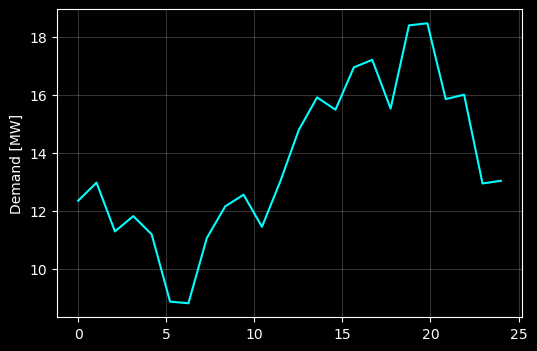

In [36]:
n_hours = 24  # hours per day
n_days = 1  # days to model
N = n_hours*n_days  # total number of time steps
phase_shift = 0  # horizontal shift [radians]
base_shift = 2  # vertical shift [units of demand]
hours = np.linspace(0,N,N)
total_demand = 328.16  # [MWh], sets the total demand [units of energy]

demand = (np.sin((hours*np.pi/n_hours*2+phase_shift))*-1+np.ones(N)*(base_shift+1))

np.random.seed(1234) # sets the seed for repeatability

noise = np.random.random(N)
demand += noise

demand = demand/demand.sum() * total_demand  # rescale

with plt.style.context("dark_background"):
    plt.plot(hours, demand, color='cyan')
    plt.ylabel('Demand [MW]')
    plt.grid(alpha=0.2)
    plt.show()

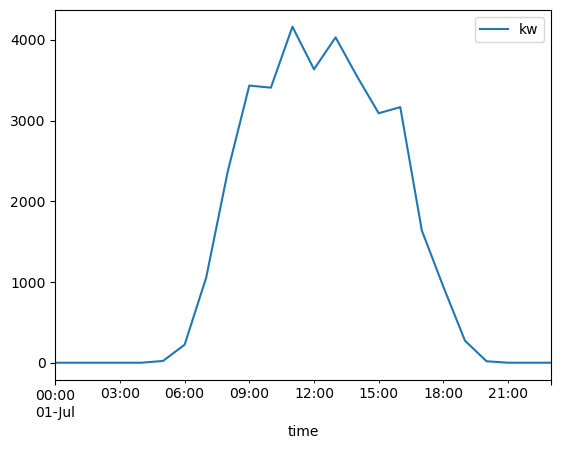

In [38]:
url = "https://raw.githubusercontent.com/samgdotson/2021-dotson-ms/refs/heads/master/data/solarfarm_data.csv"
solar_power = pd.read_csv(url, usecols=['time', 'kw'], parse_dates=True, index_col='time')

# choose a single day
solar_day = solar_power.loc['2016-07-01']
solar_day.plot();plt.show()
solar_day_ener = [0,0,0,0,0,22.15,
                  223.25,1052.75,2368.25,3433,3406.75,4161.75,
                  3634.5,4030.25,3545,3090,3165.75,1637.75,
                  940,273.25,18.0475,0,0,0]
df_solar = pd.DataFrame(solar_day_ener, columns=['Energy'])

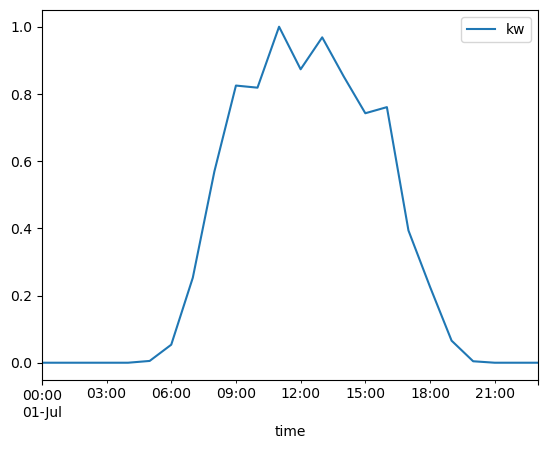

In [39]:
#normalizing solar data
norm_solar_data = solar_day/solar_day.max()
norm_solar_data.plot();plt.show()

In [40]:
solar_ener = df_solar['Energy'].values
solar_ener

array([   0.    ,    0.    ,    0.    ,    0.    ,    0.    ,   22.15  ,
        223.25  , 1052.75  , 2368.25  , 3433.    , 3406.75  , 4161.75  ,
       3634.5   , 4030.25  , 3545.    , 3090.    , 3165.75  , 1637.75  ,
        940.    ,  273.25  ,   18.0475,    0.    ,    0.    ,    0.    ])

In [41]:
from osier import total_cost
problem = CapacityExpansion(technology_list = UIUC_mix,
                            demand=demand*MW,
                            solar=solar_ener,
                            upper_bound= 1 / lib.solar.capacity_credit,
                            objectives = [total_cost],
                            solver=solver)  # the objectives must be passed as a LIST of functions!

In [42]:
algorithm = NSGA2(pop_size=20)

import time
start = time.perf_counter()
res = minimize(problem,
               algorithm,
               termination=('n_gen', 10),
               seed=1,
               save_history=True,
               verbose=True)
end = time.perf_counter()
print(f"The simulation took {(end-start)/60:.3f} minutes.")

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      1 |             - |             -
     2 |       40 |      1 |  0.000000E+00 |             f
     3 |       60 |      1 |  0.4087241771 |         ideal
     4 |       80 |      1 |  0.3040092088 |         ideal
     5 |      100 |      1 |  0.1660787453 |         ideal
     6 |      120 |      1 |  0.2527924536 |         ideal
     7 |      140 |      1 |  0.0547533158 |         ideal
     8 |      160 |      1 |  0.0933084804 |         ideal
     9 |      180 |      1 |  0.0881910857 |         ideal
    10 |      200 |      1 |  0.0886047265 |         ideal
The simulation took 4.790 minutes.


In [43]:
technologies = []
for X,tech in zip(res.X,problem.technology_list):
    tech.capacity = X*problem.max_demand
    technologies.append(tech)
display(technologies)
# normalize the solar energy array
solar_ener = (solar_ener / solar_ener.max()) * res.X[2]*problem.max_demand
net_dem = demand*MW - solar_ener
display(f"Max solar production: {solar_ener.max()}")

model = DispatchModel(technology_list=[technologies[0],technologies[1]],
                      net_demand=net_dem)
model.solve(solver=solver)
model.results

[NaturalGas_Conv: 19.748551680068616 MW,
 Coal_Conv: 0.1394501296646982 MW,
 SolarPanel: 0.7090482705670523 MW]

'Max solar production: 0.7090482705670523 MW'

,NaturalGas_Conv,Coal_Conv,Curtailment,Cost
0,12.213324,0.13945,-0.0,0.000276
1,12.835672,0.13945,-0.0,0.00029
2,11.155224,0.13945,-0.0,0.000253
3,11.683078,0.13945,-0.0,0.000265
4,11.054385,0.13945,-0.0,0.00025
5,8.733800,0.13945,-0.0,0.000199
6,8.642591,0.13945,-0.0,0.000196
7,10.749314,0.13945,-0.0,0.000244
8,11.614960,0.13945,-0.0,0.000263
9,11.834830,0.13945,-0.0,0.000268


In [20]:
from osier import get_tech_names
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    bplot = ax.boxplot(res.X,
                       patch_artist=True,
                       tick_labels=get_tech_names(problem.technology_list))
    ax.set_ylabel("Fraction of Peak Demand")

    # fill with colors
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    for median in bplot['medians']:
        median.set_color('red')

    ax.yaxis.grid(True, alpha=0.2)
    plt.show()


ValueError: Dimensions of labels and X must be compatible